# Hybrid Models

There are generally 2 ways a regression algorithm can make predictions, either by feature based transforms, or target based transforms.<br>
- Feature-transforming algorithms learn a transform that allow them to predict the target using some weighted combination of the input features. Linear regression and neural nets are of this kind.<br>
- Target-transforming algorithms group the input features in the training set and generate a prediction based on the average of the groups target values. Decision trees and nearest neighbors are of this kind.

A strength of linear regression is that it can extrapolate new values.  So it's great at following a trend even if it has never seen particular input values. A weakness is that it's an averaging algorithm, it's not good at accurately forcasting data that falls off it's hyperplane.<br>
A strength of decision tree based algorithms is that they are particularly good at accurately forcasting data. A weakness is their predictions are bound by the averages found withen the original training set.  So they cannot extrapolate trend beyond what they have seen during training.<br>

To utilize the strengths of both algorithms (and in the process minimize each weakness)<br>
   1. Use linear regression to detrend data
   2. Use a decision tree based algorithm to make predictions on the residuals left over from 1.
   
This can be done using a series of Jupyter notebook cells, but it's a bit more foolproof if we wrap these 2 algorithms in an object with a scikitlearn type of interface

See <a href="https://www.kaggle.com/code/ryanholbrook/hybrid-models">Hybrid Models</a> for original Kaggle lesson.<br>
See <a href="https://www.kaggle.com/code/kperkins411/time-series-bonus-lesson-unofficial/edit">Time Series Bonus Lesson (Unofficial)</a> for additional hybrid model insights

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [2]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))
len(df)

747

# Lags

## Are lags predictive?

/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


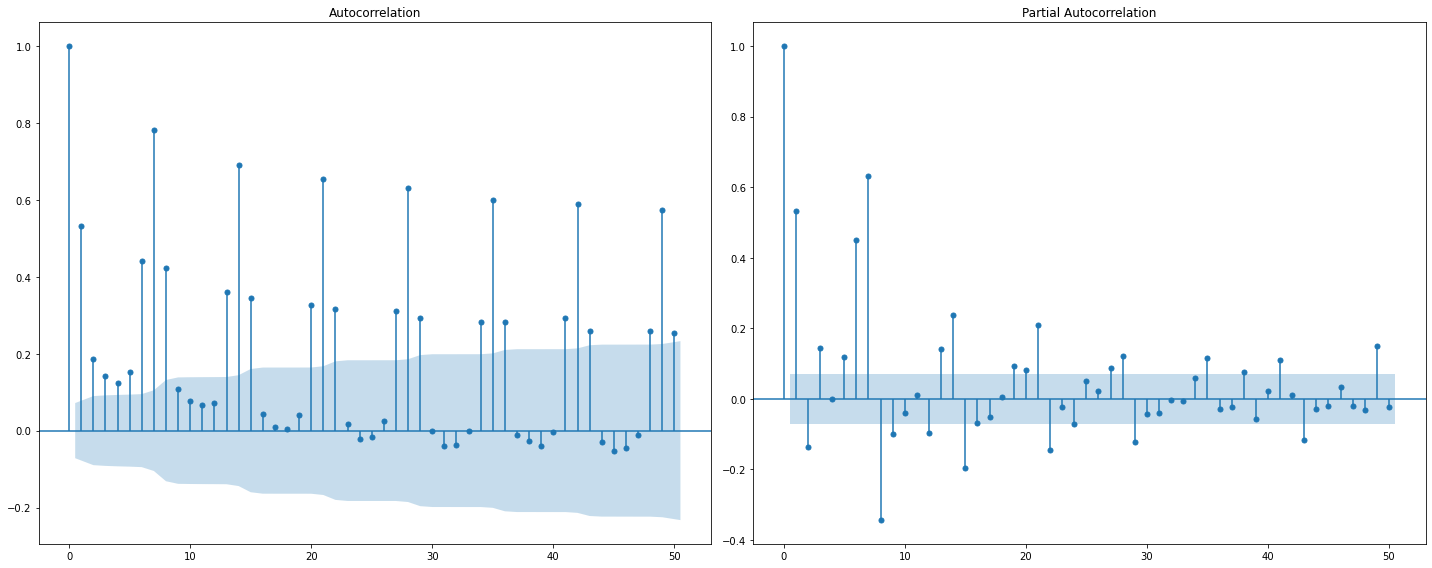

In [3]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(20,8))
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1)) 

# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.NumVehicles.tolist(), lags=50, ax=acf_ax)
plot_pacf(df.NumVehicles.tolist(), lags=50, ax=pacf_ax)
plt.tight_layout()  #removes the second plot

## Yes, add them to the dataframe
These plots show that past values are predictive of future values, so add them to the dataset
can do 7 or 14 or 21, start with 7

# Feature Engineering

## Holidays seem to have an effect on tunnel traffic, add a holiday variable to indicate whether its a holiday or not

### Create a calander to track local holidays

In [4]:
# create a calander of swiss holidays to mark in the dataset
#see https://sodocumentation.net/pandas/topic/7976/holiday-calendars
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

#You can do this for any nationality, find all the holidays and create a Holiday calendar
class SwissHolidayCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for Swiss
      - 1 January: New Year's Day
      - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
      - 1 August: National Day
      - 25 December: Christmas Day
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),  #notice that this is 39 days after easter of the year in question
        Holiday('National Day', month=8, day=1),
        Holiday('Christmas Day', month=12, day=25)
    ]
    
# want US holidays?  There is a package for that that operates like the custom calendar above
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()

In [5]:
df.tail()

,NumVehicles,Time
Date,,
2005-11-12,104646,742
2005-11-13,94424,743
2005-11-14,112165,744
2005-11-15,114296,745
2005-11-16,114690,746


In [6]:
# Creating a custom calendar
cal = SwissHolidayCalendar()

#Find all holidays in the tunnel traffic time series
hols=cal.holidays(start=str(df.index[0]), end=str(df.index[len(df)-1]))
hols

DatetimeIndex(['2003-12-25', '2004-01-01', '2004-05-20', '2004-08-01',
               '2004-12-25', '2005-01-01', '2005-05-05', '2005-08-01'],
              dtype='datetime64[ns]', freq=None)

### Add swiss holidays to dataframe

In [7]:
def add_holidays(df,hols):
    '''
    adds a holiday column to df with a 1 if day is a holiday, 0 otherwise
    returns modified df
    '''
    df['Holiday'] = df.index.isin(hols).astype(int)
    return df
df=add_holidays(df,hols)
# df[50:60]

### Travel days around a holiday are probably important as well

In [8]:
#do people travel 2 or 3 days before holiday?
#add another column which indicates travel days around holiday (default to 1 before and 1 after?)
def add_holiday_travel_days(df,hols, numb_days=1):
    '''
    adds 'Holiday_travel_day' column to df with a 1 if withen x days of holiday, 0 otherwise
    df
    hols: holidays
    numb_days: numb days around holiday to add
    returns modified df
    '''
    df['Holiday_travel_day']=0
    for hol in hols:
        for i in range(1,numb_days+1):
            df.loc[hol- pd.DateOffset(days=i),'Holiday_travel_day']=1
            df.loc[hol+ pd.DateOffset(days=i),'Holiday_travel_day']=1
    return df

#mark travel days around holidays
df=add_holiday_travel_days(df,hols,2)

#shows Christmas and new years
# df[40:60]

## It's helpful to know if it's a workday or a weekend, so add a column that indicates that

In [9]:
## maybe mark whether its a workday or a weekend?  This information is probably encoded in the lags already
#is it a workday or weekend
df['wd'] = 1  #its a workday
df.loc[df.index.dayofweek > 4, 'wd'] = 0  # >4 is weekend

## Get train test split

In [10]:
y=df['NumVehicles']
df=df.drop(columns=['NumVehicles'])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42, shuffle=False)

# The hybrid Model

Predicts travel for the next day based on the current date, previous n lag values and holiday and holiday_travel_day values. 
The model has 2 methods:<br>
fit:
1. Fit a linear regressor (model_1) to a train set
2. Calculate predictions (preds) on train set
3. Calculate residuals (target-preds) to detrend the train set
4. Fit catboost (model_2) on train set residuals 

predict:
1. model_1.predict + model_2.predict

Their are some problems however, the first is the lags, when predicting we have to have a list of n previous residuals. This means that the start of test set will be missing the end of the training sets lag values unless they are saved somehow.<br>
The second problem is that the model_2 depends on the residulas calculated by the first model for the lags. Specifically model_2 works on the detrended data, these have to be calculated and saved, which means the model has to see the test data to calculate the lags.  This is not a problem in terms of leakage, it just makes keeping track of data and ensuring the model does not accidentally 'see' future or current data that much harder.


In [12]:
from utils import BoostedHybrid

## Partition dataset

In [13]:
#get our target value, the training set for linear regression, and the training set for catboost
X_1=X_train.loc[:,['Time']]
X_2=X_train
# X_2=X_train.loc[:,['Time','Holiday','Holiday_travel_day','wd']]
# X_2=df.loc[:,['Time']]
# display(y)
# display(X_1)
# display(X_2)

## Train the model on train set

In [14]:
from sklearn import linear_model
from catboost import CatBoostRegressor
hm=BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=3)

#fit the model
hm.fit(X_1,X_2,y_train)

## Get test set predictions and Rsquared

In [15]:
#get our target value, the training set for linear regression, and the training set for catboost
#get predictions on test set
preds=hm.predict(X_test.loc[:,['Time']],X_test,y_test,False)
# preds

In [16]:
from utils import rsquared
score=rsquared(preds, y_test[-len(preds):])
score

0.9334719287380104

# Holy Moly!  Our last score was .67!  Did the holiday travel make the difference?

Take out all the holiday and holiday_travel and week verses weekday features and see.  Or look at the permutation importance

# Lets plot predictions verses actuals

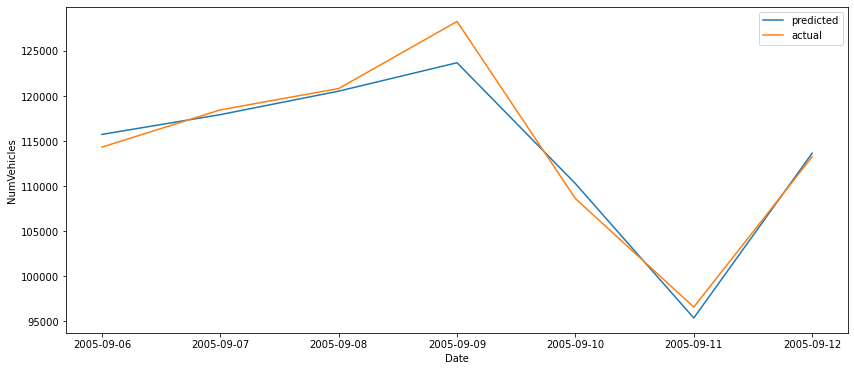

In [17]:
df_preds = pd.DataFrame(index=df.index[-len(preds):])
df_preds['NumVehicles']=preds
df_y=pd.DataFrame(index=df.index[-len(preds):])
df_y['NumVehicles']=y[-len(preds):]

fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(data=df_preds[:7], x=df_preds.index[:7], y='NumVehicles',ax=ax1)
_=sns.lineplot(data=df_y[:7], x=df_y.index[:7], y='NumVehicles',ax=ax1)
plt.legend(labels=["predicted","actual"])

In [18]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

corrs = [crosscorr(df_preds.NumVehicles,df_y.NumVehicles, lag=i) for i in range(12)]

In [19]:
corrs

[0.9682343447983454,
 0.2836975611537893,
 -0.3350121659059216,
 -0.2947998724994186,
 -0.3128923514300185,
 -0.23858049371416143,
 0.28823178369428065,
 0.916639106861615,
 0.21210284779598934,
 -0.39325920009903576,
 -0.34695849321657035,
 -0.3622546313369507]

# <mark> Permutation Importance 

In [20]:
from sklearn.inspection import permutation_importance

In [21]:
%%time
feature_names=X_test.columns
result = permutation_importance(
    hm.model_2, X_test, y_test[-len(X_test):], n_repeats=10, random_state=42, n_jobs=2, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 34.9 ms, sys: 32.9 ms, total: 67.8 ms
Wall time: 877 ms


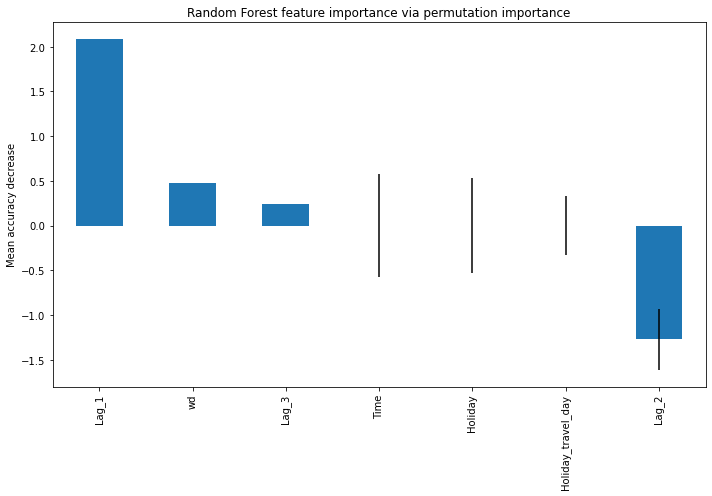

In [22]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()